# Survival Model #

@roman_avj

7 nov 2023

In [77]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import boto3
import sqlalchemy

from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

from xgbse import XGBSEStackedWeibull
from xgbse.extrapolation import extrapolate_constant_risk
import lifelines

from scipy.integrate import simpson
from scipy.optimize import brentq

import geopandas as gpd
import folium

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from xgbse.metrics import (
    approx_brier_score,
    dist_calibration_score,
    concordance_index
)


# Setup

## Data

In [78]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_rent.parquet')
df_model.info()

# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 28.5+ MB


## Wrangle

In [79]:
# get maxmimum time2event
# get a random id from df_max, first trye for event == 1, then for event == 0
id_max = df_max[df_max['event'] == 1]['id'].sample(1, random_state=8).values[0]
if pd.isna(id_max):
    id_max = df_max[df_max['event'] == 0]['id'].sample(1, random_state=8).values[0]

# for id_max add 1 to time2event and set event = 1
df_model.loc[df_model['id'] == id_max, 'time2event'] =\
     df_model.loc[df_model['id'] == id_max, 'time2event'] + 1

df_model.loc[df_model['id'] == id_max, 'event'] = 1

## Transform

In [80]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bathrooms', 'num_parking_lots']
vars_x_woe = ['woe_marketplace', 'woe_id_sepomex']
vars_x_numerical = [
    'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living'
    ]
vars_x_binary = ['pets_allowed']
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_time + vars_x_woe

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

20
20


In [81]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical + vars_x_discrete + vars_x_binary + vars_x_geographic})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       26541 non-null  category
 1   property_type                      26541 non-null  category
 2   diff_first_prediction              26541 non-null  float64 
 3   prediction_price_per_square_meter  26541 non-null  float64 
 4   surface_total                      26541 non-null  float64 
 5   page_on_marketplace                26541 non-null  float64 
 6   is_new_property_prob               26541 non-null  float64 
 7   total_cost_of_living               26541 non-null  float64 
 8   green_index                        26541 non-null  float64 
 9   days_active                        26541 non-null  float64 
 10  relative_cost_of_living            26541 non-null  float64 
 11  pets_allowed                       26541 

In [82]:
# one hot encoding #
data_x_numeric = OneHotEncoder().fit_transform(data_x)
colnames_x_numeric = data_x_numeric.columns

# boxcox (yeo-johnson) transformation BY property type #
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    'prediction_price_per_square_meter', 'surface_total', 'is_new_property_prob'
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

# scale #
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get scaler transformation
data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])
# to numeric
data_x_numeric = data_x_numeric.to_numpy()


dropped categorical variable 'listing_type', because it has only 1 values


In [83]:
# to numeric
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,green_index,days_active,relative_cost_of_living,pets_allowed,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_id_sepomex
0,0.0,-0.747566,-1.290174,-0.613845,-0.348624,-0.544545,-0.572298,-1.048412,-1.296468,-1.022836,1.0,0.310737,-0.768490,19.478474,-99.210293,1.224647e-16,-1.000000,0.025046,0.17534
1,0.0,-1.030759,-0.932039,-0.964186,-1.038756,-0.158285,1.141924,-1.048412,-1.296468,0.881731,0.0,-1.097058,-0.170226,19.478672,-99.206866,1.224647e-16,-1.000000,0.235393,0.17534
2,0.0,-1.738722,-1.486820,-0.578656,0.492888,-0.673979,-0.776076,-1.048412,-1.296468,-1.661169,0.0,-1.097058,0.128907,19.479462,-99.207931,-5.000000e-01,-0.866025,-0.113731,0.17534


In [84]:
# give the id's of the rows
data_x_numeric = np.hstack((data_x_numeric, df_model['id'].to_numpy().reshape(-1,1)))

# get the row with id_max
data_x_max = data_x_numeric[df_model['id'] == id_max]
idx_delete = df_model[df_model['id'] == id_max].index

# delete row_id_max from data_x_numeric
data_x_numeric = np.delete(data_x_numeric, idx_delete, axis=0)

# also delete from data_y
data_y_max = data_y[idx_delete]
data_y = np.delete(data_y, idx_delete, axis=0)

## Train & Test

In [85]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42
)

In [86]:
# get the id's of the train and test
train_ids = X_train[:, -1]
test_ids = X_test[:, -1]

# add id_max to X_train & y_train
X_train = np.vstack([X_train, data_x_max])
y_train = np.hstack([y_train, data_y_max])

# delete the id's from the data
X_train = np.delete(X_train, -1, axis=1)
X_test = np.delete(X_test, -1, axis=1)

In [87]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Get Best Model

In [88]:
# create vanilla model
class sklearn_wei(XGBSEStackedWeibull):
  
    def get_params2(self):
        return(self.get_params()['xgb_params'])
      
    def set_params(self,**params):
      old_params = self.get_params2()
      old_params.update(params)
      self.xgb_params = old_params
      return(self)

ok = sklearn_wei()

In [89]:
# cross validation
opt = BayesSearchCV(
  estimator = ok,
  scoring = make_scorer(concordance_index),
  n_iter = 5,
  random_state = 42,
  cv = StratifiedKFold(n_splits = 4, shuffle = True),
  n_jobs = -1,
  n_points = 1,
  verbose = 1,
  search_spaces = {
    'max_depth': Integer(low = 2, high = 32, prior = 'log-uniform'),
    'learning_rate': Real(0.01, 1, "log-uniform"),
    'reg_alpha': Real(low=0, high = 1,prior = "uniform"),
    'reg_lambda': Real(low=0, high = 1,prior = "uniform"),
  },
  fit_params = {}
 )

opt.fit(
  X_train_bis,
  y_train_bis,
  time_bins = range(1, 125, 1),
  validation_data= (X_val, y_val),
  early_stopping_rounds=10,
  verbose_eval=50
)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:11.35085
[0]	validation-aft-nloglik:11.35169
[0]	validation-aft-nloglik:11.34942
[0]	validation-aft-nloglik:11.35308
[50]	validation-aft-nloglik:3.59036
[50]	validation-aft-nloglik:3.59085
[50]	validation-aft-nloglik:3.58863
[50]	validation-aft-nloglik:3.59038
[92]	validation-aft-nloglik:3.57276
[99]	validation-aft-nloglik:3.57191
[100]	validation-aft-nloglik:3.57153
[100]	validation-aft-nloglik:3.57014
[106]	validation-aft-nloglik:3.57203
[108]	validation-aft-nloglik:3.57059
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:6.20220
[16]	validation-aft-nloglik:3.60871
[0]	validation-aft-nloglik:6.19729
[0]	validation-aft-nloglik:6.18854
[0]	validation-aft-nloglik:6.20543
[17]	validation-aft-nloglik:3.61213
[17]	validation-aft-nloglik:3.61897
[17]	validation-aft-nloglik:3.61568
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[0]	validation-aft-nloglik:11.16618
[0]	validation-aft-nloglik:11.16322
[0]	validation-aft-nloglik:11.16751


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:11.16296
[50]	validation-aft-nloglik:3.57807
[50]	validation-aft-nloglik:3.58040
[50]	validation-aft-nloglik:3.57717
[50]	validation-aft-nloglik:3.57847
[79]	validation-aft-nloglik:3.57384
[86]	validation-aft-nloglik:3.57292
[87]	validation-aft-nloglik:3.57394
[88]	validation-aft-nloglik:3.57373
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:6.69748
[0]	validation-aft-nloglik:6.69056
[0]	validation-aft-nloglik:6.70361
[0]	validation-aft-nloglik:6.69277
[33]	validation-aft-nloglik:3.58573
[33]	validation-aft-nloglik:3.58346
[39]	validation-aft-nloglik:3.58654
[47]	validation-aft-nloglik:3.58340
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[0]	validation-aft-nloglik:6.94108


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:6.94529
[0]	validation-aft-nloglik:6.94439
[0]	validation-aft-nloglik:6.94976
[18]	validation-aft-nloglik:3.59170
[19]	validation-aft-nloglik:3.59098
[21]	validation-aft-nloglik:3.58960
[25]	validation-aft-nloglik:3.58403
[0]	validation-aft-nloglik:11.35122
[50]	validation-aft-nloglik:3.58664
[94]	validation-aft-nloglik:3.56931


BayesSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
              estimator=sklearn_wei(weibull_params={},
                                    xgb_params={'aft_loss_distribution': 'normal',
                                                'aft_loss_distribution_scale': 1,
                                                'booster': 'dart',
                                                'colsample_bynode': 0.5,
                                                'eval_metric': 'aft-nloglik',
                                                'learning_rate': 0.05,
                                                'max_depth': 8,
                                                'min_child_weight': 50,
                                                'objective': 'survival:aft',
                                                'subs...
              scoring=make_scorer(concordance_index),
              search_spaces={'learning_rate': Real(low=0.01, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=32, prior='log-uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [90]:
df_results = (
  pd.DataFrame(opt.cv_results_).sort_values(by = 'rank_test_score', ascending = True)
  .assign(
    max_depth=lambda x: x['params'].apply(lambda y: y['max_depth']),
    learning_rate=lambda x: x['params'].apply(lambda y: y['learning_rate']),
    reg_alpha=lambda x: x['params'].apply(lambda y: y['reg_alpha']),
    reg_lambda=lambda x: x['params'].apply(lambda y: y['reg_lambda'])
    )
    [[
      'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda',
      'mean_test_score', 'std_test_score', 'mean_fit_time']]
  )

df_results

,max_depth,learning_rate,reg_alpha,reg_lambda,mean_test_score,std_test_score,mean_fit_time
0,15,0.066101,0.932868,0.315800,0.641016,0.004616,8.574592
2,26,0.077565,0.104859,0.433333,0.640189,0.003011,7.001256
3,3,0.421495,0.598047,0.802765,0.628634,0.004490,0.857502
4,7,0.397289,0.526620,0.715713,0.628492,0.002742,0.560687
1,23,0.472908,0.303410,0.951224,0.620800,0.001863,0.570427


# Train Best Model

## Fit

In [91]:
# best params
best_xgbse_params = opt.best_estimator_.get_params2()
best_xgbse_params

{'objective': 'survival:aft',
 'eval_metric': 'aft-nloglik',
 'aft_loss_distribution': 'normal',
 'aft_loss_distribution_scale': 1,
 'tree_method': 'hist',
 'learning_rate': 0.0661009829541915,
 'max_depth': 15,
 'booster': 'dart',
 'subsample': 0.5,
 'min_child_weight': 50,
 'colsample_bynode': 0.5,
 'reg_alpha': 0.9328679988478339,
 'reg_lambda': 0.3157995934870487}

In [92]:
print(colnames_x_numeric)

Index(['property_type=house', 'diff_first_prediction',
       'prediction_price_per_square_meter', 'surface_total',
       'page_on_marketplace', 'is_new_property_prob', 'total_cost_of_living',
       'green_index', 'days_active', 'relative_cost_of_living', 'pets_allowed',
       'num_bathrooms', 'num_parking_lots', 'latitude', 'longitude',
       'sine_tmonth', 'cosine_tmonth', 'woe_marketplace', 'woe_id_sepomex'],
      dtype='object')


In [159]:
# add monotonic constraints
best_xgbse_params['monotone_constraints'] = len(colnames_x_numeric) * [0]
# add increasing monotonic constraints for 'diff_first_prediction'
best_xgbse_params['monotone_constraints'][colnames_x_numeric.to_list().index('diff_first_prediction')] = 1

best_xgbse_params['monotone_constraints'] = tuple(best_xgbse_params['monotone_constraints'])
best_xgbse_params

{'objective': 'survival:aft',
 'eval_metric': 'aft-nloglik',
 'aft_loss_distribution': 'normal',
 'aft_loss_distribution_scale': 1,
 'tree_method': 'hist',
 'learning_rate': 0.0661009829541915,
 'max_depth': 15,
 'booster': 'dart',
 'subsample': 0.5,
 'min_child_weight': 50,
 'colsample_bynode': 0.5,
 'reg_alpha': 0.9328679988478339,
 'reg_lambda': 0.3157995934870487,
 'monotone_constraints': (0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0)}

In [160]:
# save best params to json
import json
with open('best_params.json', 'w') as fp:
    json.dump(best_xgbse_params, fp)

In [161]:
# fit weibull
xgbse_weibull = XGBSEStackedWeibull(best_xgbse_params)
xgbse_weibull.fit(
    X_train_bis, y_train_bis,
    validation_data=(X_val, y_val),
    early_stopping_rounds=10,
    verbose_eval=50,
    time_bins = range(1, 125, 1)
)

[0]	validation-aft-nloglik:11.35263


[50]	validation-aft-nloglik:3.58781
[84]	validation-aft-nloglik:3.57023


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.0661009829541915,
                                'max_depth': 15, 'min_child_weight': 50,
                                'monotone_constraints': (0, 1, 0, 0, 0, 0, 0, 0,
                                                         0, 0, 0, 0, 0, 0, 0, 0,
                                                         0, 0, 0),
                                'objective': 'survival:aft',
                                'reg_alpha': 0.9328679988478339,
                                'reg_lambda': 0.3157995934870487,
                                'subsample': 0.5, 'tree_method': 'hist'})

## Train

In [162]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    mape = np.mean(np.abs((df[df['event']]['predicted_time'] - df[df['event']]['observed_time']) / df[df['event']]['observed_time']))
    return pd.Series({'rmse': rmse, 'mape': mape, 'cindex': cindex})

def get_prediction_df(X, y, colnames, model):
    # get rmse, mape and cindex by listing & property type
    df_pred = (
        pd.DataFrame(X, columns=colnames)
        .assign(
            observed_time=y['Survival_in_days'],
            event=y['Status'],
            predicted_time=model.predict(X).pipe(get_xgbse_mean_time),
            risk_score=lambda x: - x['predicted_time']
        )
        .rename(columns={
        'property_type=house': 'property_type',
        })
        .assign(
            property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
        )  
    )

    return df_pred


In [163]:
# get prediction df
df_pred = get_prediction_df(X_train, y_train, colnames_x_numeric, xgbse_weibull)

# get metrics
table_metrics = (
    df_pred
    .groupby([ 'property_type'])
    .apply(get_metrics)
)

# save
# os.makedirs("../../results/best_models", exist_ok=True)
# table_metrics.to_csv("../../results/best_models/best_survival_model_metrics.csv")
table_metrics

,rmse,mape,cindex
property_type,,,
apartment,23.581992,0.845125,0.713394
house,25.278210,0.863320,0.717089


## Test

### General Metrics

In [164]:
# get prediction df
df_pred = get_prediction_df(X_test, y_test, colnames_x_numeric, xgbse_weibull)

# get metrics
(
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
)

,rmse,mape,cindex
property_type,,,
apartment,26.011494,0.928436,0.655331
house,29.248761,1.053253,0.632782


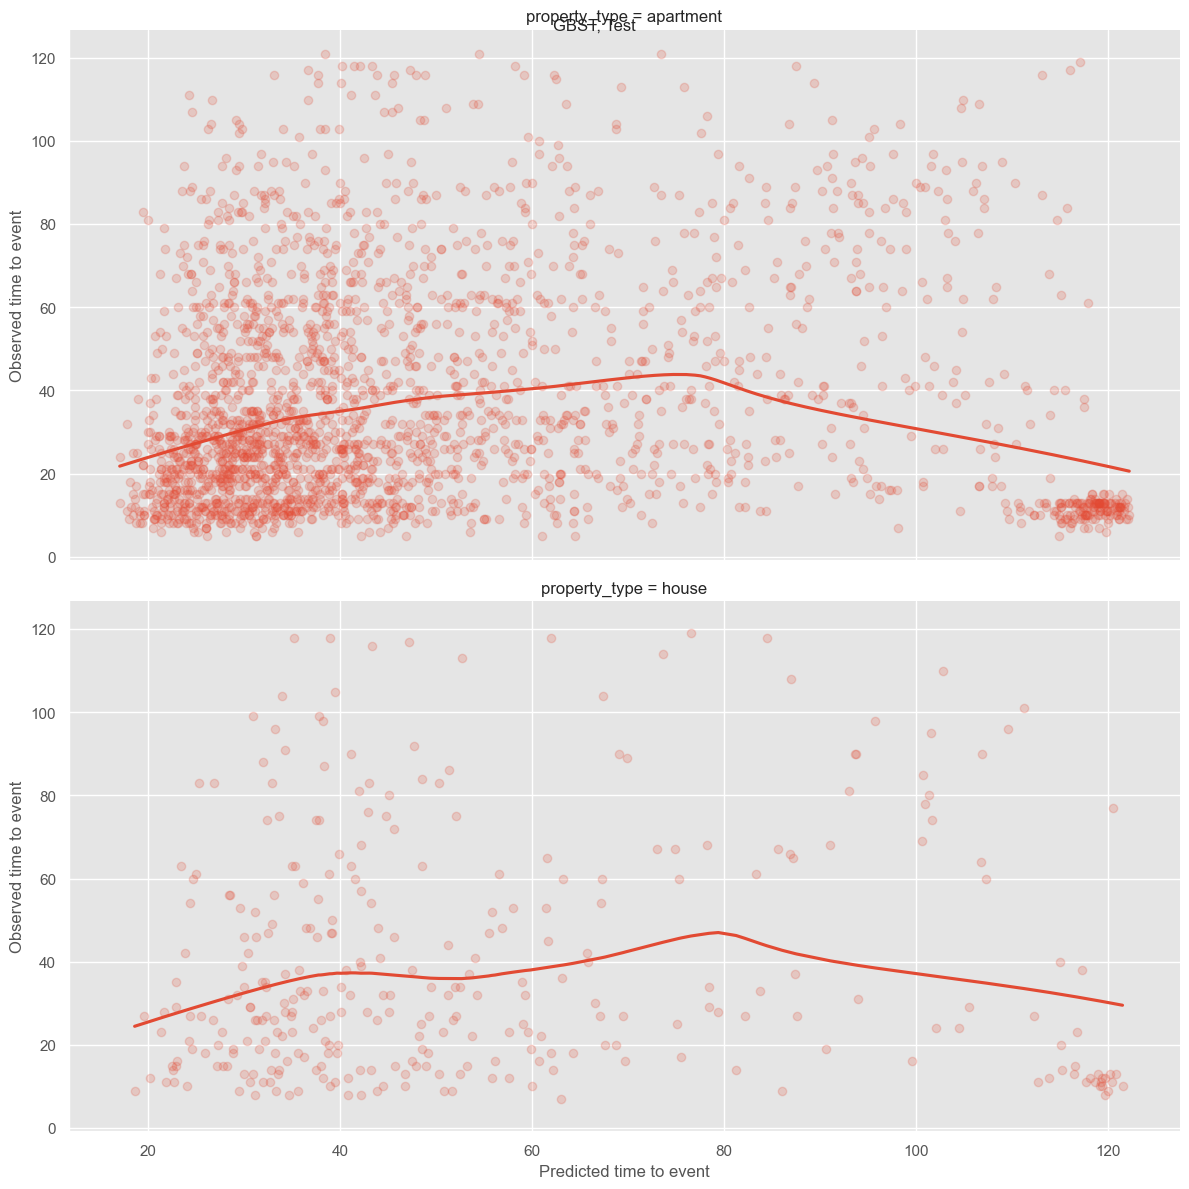

In [165]:
# plot a regplot observed vs predicted, facet grid listing_type and property_type
g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GBST, Test')
plt.show()

In [166]:
# get feature importance
pd.Series(xgbse_weibull.feature_importances_.values(), index=colnames_x_numeric).sort_values(ascending=False)

is_new_property_prob                 847.0
prediction_price_per_square_meter    818.0
longitude                            760.0
surface_total                        702.0
latitude                             666.0
total_cost_of_living                 589.0
days_active                          584.0
relative_cost_of_living              548.0
page_on_marketplace                  534.0
green_index                          528.0
sine_tmonth                          429.0
diff_first_prediction                408.0
woe_marketplace                      392.0
num_parking_lots                     278.0
cosine_tmonth                        232.0
num_bathrooms                        181.0
woe_id_sepomex                       131.0
pets_allowed                         114.0
property_type=house                   48.0
dtype: float64

### Brier Score

In [167]:
# get brier score ofr property_type and listing_type
def get_brier_score(df, colnames, model):
    brier_score = approx_brier_score(
        y_true=np.array(
                list(zip(df['event'], df['observed_time'])),
                dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
                ),
        survival=model.predict(df[colnames].values),
    )
    return brier_score

# get brier score by listing_type and property_type
(
    df_pred
    .assign(
        property_type2=lambda x: np.where(x['property_type'] == 'house', 1, 0),
    )
    .rename(columns={
        'property_type2': 'property_type=house',
    })
    .sample(frac=0.95, random_state=42)
    .groupby(['property_type'])
    .apply(lambda x: get_brier_score(x, colnames=colnames_x_numeric, model=xgbse_weibull))
)

/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values


property_type
apartment    0.135000
house        0.150227
dtype: float64

# Survival Curves

In [168]:
def get_survival_df(X, y, model, ids, df, cols):
    # predict 
    df_predictions = xgbse_weibull.predict(X)

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy)
df_surv

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

### Random

In [169]:
df_surv_long = (
    df_surv
    .groupby(['property_type'])
    .sample(10, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,property_type,day,survival
18,00ef1409522d22cb701eddbbc86e0b4f,house,1,0.997807
38,00ef1409522d22cb701eddbbc86e0b4f,house,2,0.993170
58,00ef1409522d22cb701eddbbc86e0b4f,house,3,0.986748
78,00ef1409522d22cb701eddbbc86e0b4f,house,4,0.978827
98,00ef1409522d22cb701eddbbc86e0b4f,house,5,0.969597
...,...,...,...,...
2387,ee252855316bbb62c4dd5ffffba13f60,apartment,120,0.001555
2407,ee252855316bbb62c4dd5ffffba13f60,apartment,121,0.001424
2427,ee252855316bbb62c4dd5ffffba13f60,apartment,122,0.001302
2447,ee252855316bbb62c4dd5ffffba13f60,apartment,123,0.001191


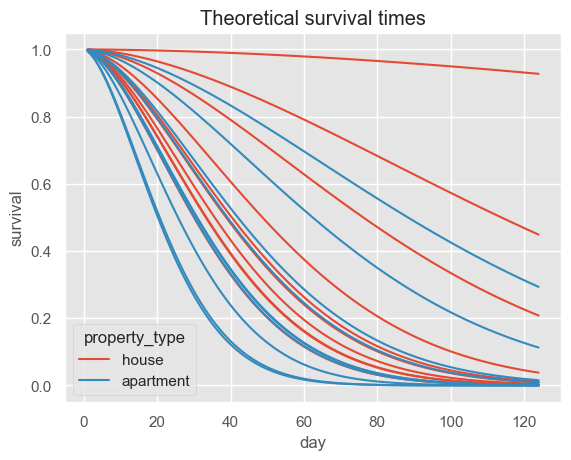

In [170]:
sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='property_type', estimator=None)
plt.title(f"Theoretical survival times")
plt.show()


### Extended

In [171]:
def get_extended_survival_df(X, y, model, ids, df, cols, tau=365):
    # predict 
    df_predictions = extrapolate_constant_risk(
        survival=model.predict(X),
        final_time=tau,
        intervals=1
    )

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_extended_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy, tau=365)

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

In [172]:
# to long
df_surv_long = (
    df_surv
    .groupby(['property_type'])
    .sample(100, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,property_type,day,survival
108,00ef1409522d22cb701eddbbc86e0b4f,house,1,0.997807
308,00ef1409522d22cb701eddbbc86e0b4f,house,2,0.993170
508,00ef1409522d22cb701eddbbc86e0b4f,house,3,0.986748
708,00ef1409522d22cb701eddbbc86e0b4f,house,4,0.978827
908,00ef1409522d22cb701eddbbc86e0b4f,house,5,0.969597
...,...,...,...,...
72115,ffac95ff99734034b86b8ebb5b86f7dc,house,361,0.022996
72315,ffac95ff99734034b86b8ebb5b86f7dc,house,362,0.022718
72515,ffac95ff99734034b86b8ebb5b86f7dc,house,363,0.022444
72715,ffac95ff99734034b86b8ebb5b86f7dc,house,364,0.022173


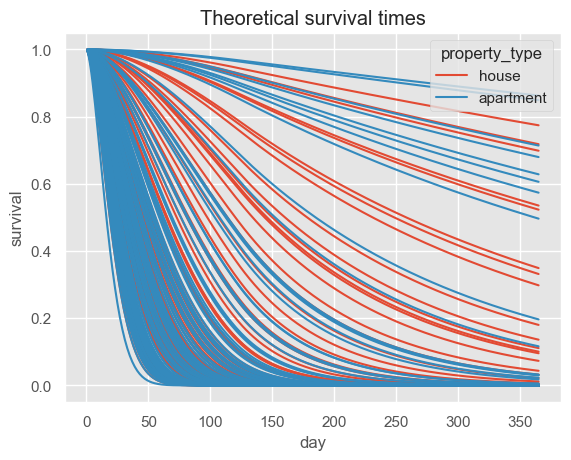

In [173]:
sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='property_type', estimator=None)
plt.title(f"Theoretical survival times")
plt.show()


### Root Finding

In [174]:
def quantile_function(day, q=0.8, group=None):
    # Calculate the empirical quantile based on 'day' and 'survival'
    quantile_value = group[group['day'] <= day]['survival'].min()
    return quantile_value - q

# Create a function to apply to each group (each 'id')
def get_quantile(group, target_quantile=0.8):
    try:
        result = brentq(quantile_function, a=1, b=365*2, args=(target_quantile, group))
    except:
        result = np.nan
    return pd.Series({'quantile_80': result})

# Apply the function to each 'id' group and store the results in a new DataFrame
result_df = df_surv_long.groupby(['id']).apply(get_quantile, target_quantile=1-0.9).reset_index().sort_values(by='quantile_80', ascending=False)
result_df

,id,quantile_80
94,71fa55f8a526cbffa9f2dc3ad2f15d8c,360.0
31,1ff15bdb6cab0ed605355143b664dffc,328.0
128,a56b3b9d425bf164a96e6fcdf92ca92b,282.0
65,45b483248827ef0b1416b679ec770937,262.0
111,8db3d872746fc6384a4053e1e57c28d2,262.0
...,...,...
166,d52e16f61263901d16ba1c0f2613dd0d,NaN
167,d555224b5449427fbf9d7a720c9d9619,NaN
172,e51337d62f9eefd90b197df4f33b4106,NaN
182,ee7c5c5171bb2b188131b1a60053c4ac,NaN


# Quantile Prediction

## Predict

In [175]:
# get predictions
df_quantile90_surv = (
    get_extended_survival_df(
        X_test, y_test, 
        xgbse_weibull, 
        ids=test_ids, 
        df=df_model, 
        cols=colnames_x_numeric_tidy, 
        tau=365*2
    )
    # .groupby(['property_type', 'event'])
    # .sample(100, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
    .groupby(['id'])
    .apply(get_quantile, target_quantile=1-0.8)
    .reset_index()
    .merge(df_model, how='inner', on='id')
)


## look calibration

### Quantile

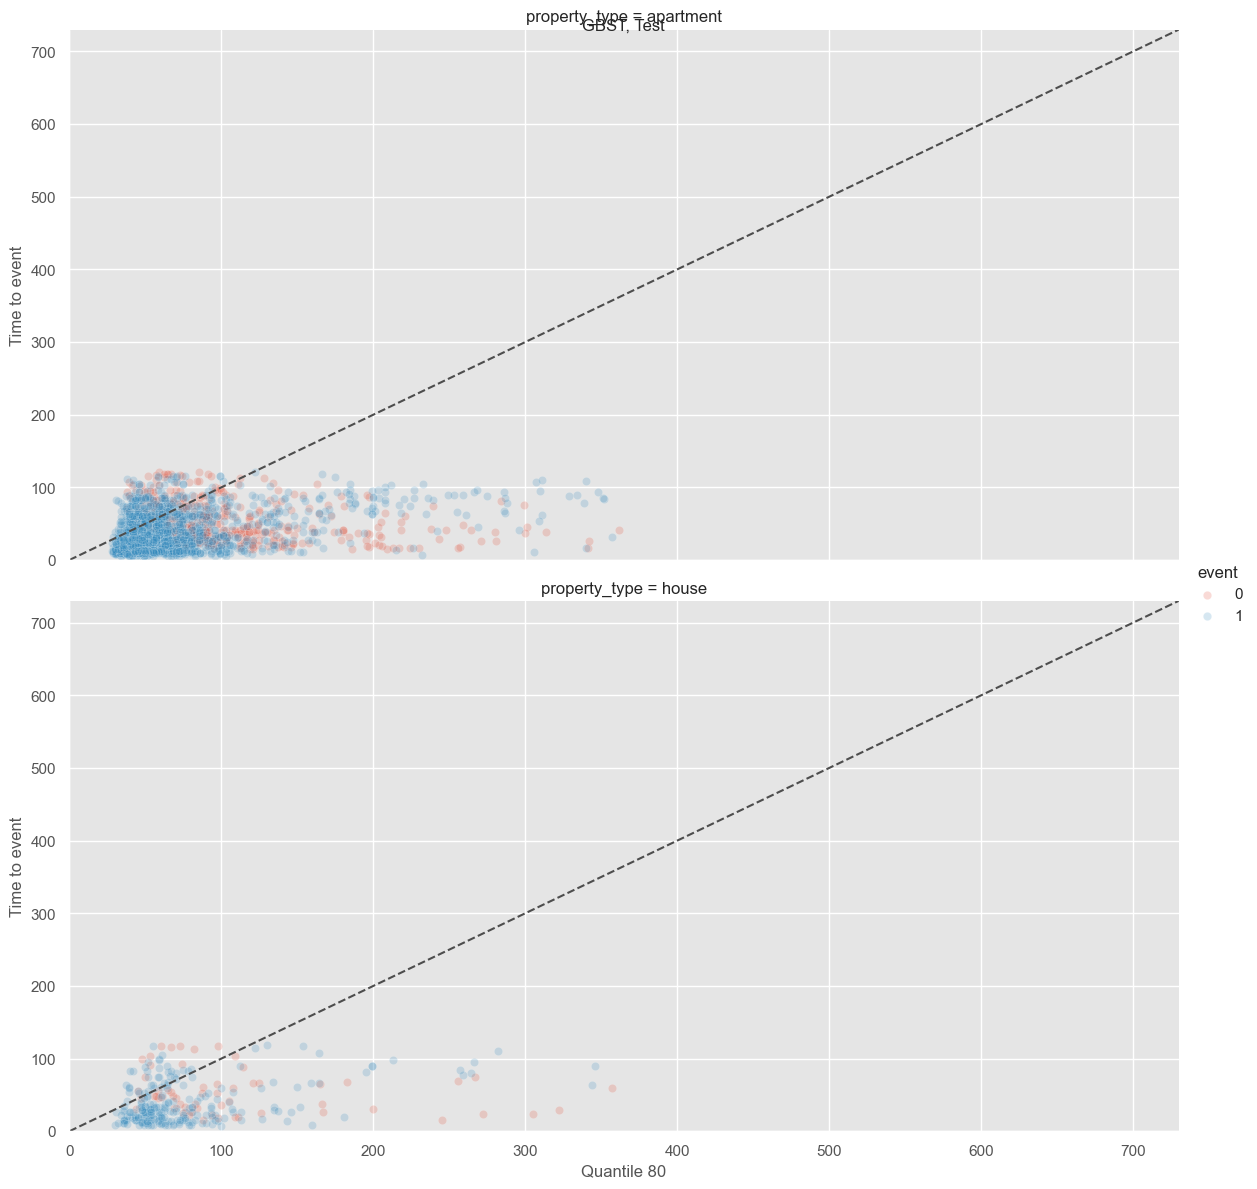

In [176]:
# plot quantile_80 vs time2event, facet grid listing_type and property_type and hue by event
g = sns.FacetGrid(df_quantile90_surv, row='property_type', hue='event')

# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)

# plot a scatter plot
g.map(sns.scatterplot, 'quantile_80', 'time2event', alpha=0.2)

# extend limits of x axis
g.set(xlim=(0, 365*2), ylim=(0, 365*2))

# Add the identity line to each facet
for ax in g.axes.flat:
    ax.plot([0, 365*2], [0, 365*2], ls="--", c=".3")

g.set_axis_labels('Quantile 80', 'Time to event')
g.fig.suptitle('GBST, Test')

# add legend
g.add_legend()

plt.show()


In [177]:
# get calibration by listing_type and property_type
(
    df_quantile90_surv
    .assign(
        is_higher=lambda x: np.where(x['time2event'] > x['quantile_80'], 1, 0),
    )
    .groupby(['property_type', 'event'])
    .agg({'is_higher': 'mean'})
)

is_higher
property_type event           
apartment     0       0.156507
              1       0.155979
house         0       0.132530
              1       0.163090

### Kaplan Mier vs Model

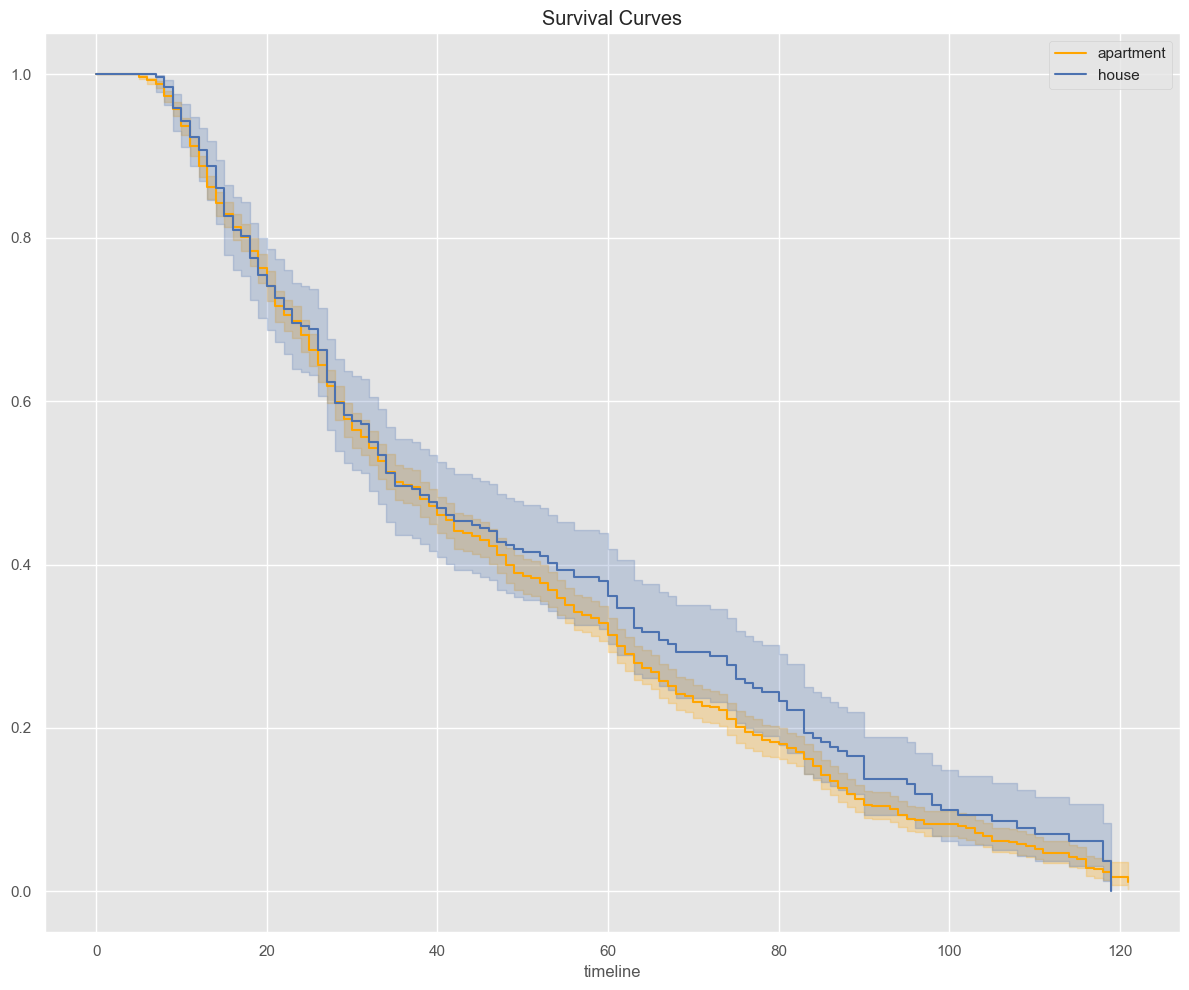

In [178]:
# create a KM plot for each listing_type and property_type if X_test
# first get dataframe with times
df_test_times = pd.DataFrame({
    'time2event': y_test['Survival_in_days'],
    'event': y_test['Status'],
    'property_type': X_test[:, 0],
    'id': test_ids
}).assign(
    property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
)


# create a KM plot for each listing_type and property_type for df_test_times
def plot_km(df):
    df = df.copy()
    ax = plt.subplot(111)

    dict_km = {}

    for property_type in ['apartment', 'house']:
        # get key
        df_rent = df[
            (df['property_type'] == property_type)
            ].copy()
        
        # estimate
        kmf = lifelines.KaplanMeierFitter()
        ax = kmf.fit(
            df_rent['time2event'],
            df_rent['event'],
            label=property_type
        ).plot_survival_function(
            ci_show=True,
            figsize=(12, 10),
            color=('b' if property_type == 'house' else 'orange'),
            title='Survival Curves'
        )

        # add km to dict
        dict_km[property_type] = kmf
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return

plot_km(df_test_times)

In [179]:
# get df test with modified values
df_test_x_numeric = pd.DataFrame(X_test, columns=colnames_x_numeric)
df_test_x_numeric

# apply mean by listing_type and property_type
df_test_x_numeric_artificial = (
    df_test_x_numeric.copy()
    .groupby(["property_type=house"])
    .apply('mean')
    .reset_index()
    )

# predict
df_test_extended_surv = (
    extrapolate_constant_risk(
        survival=xgbse_weibull.predict(df_test_x_numeric_artificial.values),
        final_time=365*2,
        intervals=1
    )
    .assign(
        property_type=df_test_x_numeric_artificial['property_type=house'].\
            apply(lambda x: 'house' if x == 1 else 'apartment'),
    )
    .melt(id_vars=['property_type'], value_vars=range(1, 365))
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .sort_values(by=['property_type', 'day'])
)
df_test_extended_surv

,property_type,day,survival
0,apartment,1.0,9.978945e-01
2,apartment,2.0,9.934361e-01
4,apartment,3.0,9.872582e-01
6,apartment,4.0,9.796342e-01
8,apartment,5.0,9.707442e-01
...,...,...,...
719,house,360.0,1.586039e-13
721,house,361.0,1.443029e-13
723,house,362.0,1.312914e-13
725,house,363.0,1.194531e-13


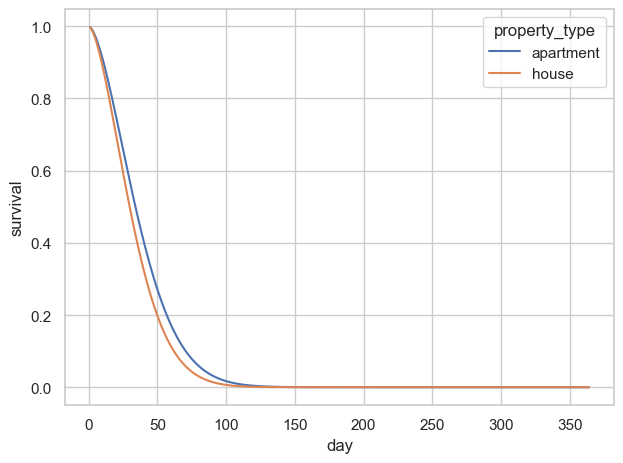

In [180]:
# plot a lineplot, colored by listing_type and linetype by property_type
sns.set_theme(style="whitegrid")
sns.lineplot(x='day', y='survival', data=df_test_extended_surv, hue='property_type', estimator=None)
plt.tight_layout()

In [181]:
# fit a kaplan meier for each listing_type and property_type and then plot
km_fits = {}
for property_type in ['apartment', 'house']:
    # get key
    df_rent = df_test_times[
        (df_test_times['property_type'] == property_type)
        ].copy()
    
    # estimate
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(
        df_rent['time2event'],
        df_rent['event'],
        label=property_type
    )
    km_fits[property_type] = kmf

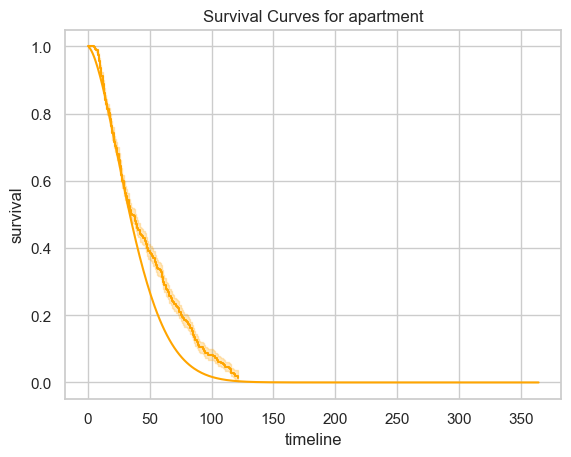

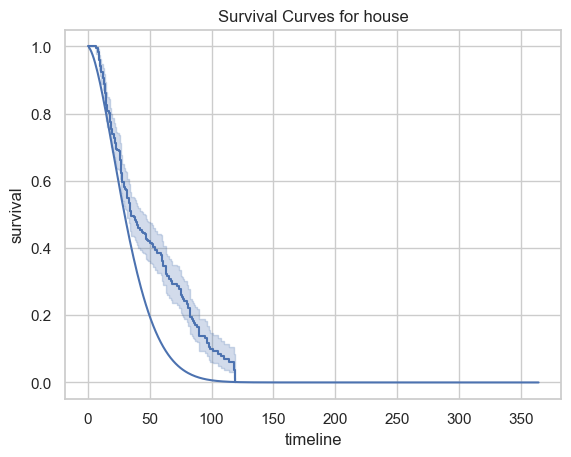

In [182]:
# plot a lineplot for each listing_type and property_type using the km and df_test_extended_surv
for property_type in ['apartment', 'house']:
    # get key

    # plot km
    km_fits[property_type].plot_survival_function(
        ci_show=True,
        color=('b' if property_type == 'house' else 'orange'),
        title=f'Survival Curves for {property_type}'
    )
    # plot lineplot
    sns.lineplot(
        x='day', y='survival', 
        data=df_test_extended_surv.query(f"property_type == '{property_type}'"), 
        estimator=None,
        color=('b' if property_type == 'house' else 'orange'),
    )
    # dont show legend
    plt.legend().remove()
    plt.show()


# Business Sense

For a given listing, i should watch:

- higher price implies more time
- higher woe implies less time

In [190]:
# Function to create synthetic observations
def create_synthetic_observations(df_examples, multiplier):
    df_synthetic = pd.DataFrame()
    
    for _, row in df_examples.iterrows():
        # Get the original row data
        diff_first_prediction = row['diff_first_prediction']
        
        # Create new rows for each multiplier
        for mult in multiplier:
            new_diff_first_prediction = (diff_first_prediction + 1 - 1/mult) * mult
            
            # Create a new row with modified values
            new_row = row.copy()
            new_row['diff_first_prediction'] = new_diff_first_prediction
            new_row['label_price'] = mult
            
            # Concatenate the new row to the synthetic dataframe
            df_synthetic = pd.concat([df_synthetic, new_row.to_frame().transpose()], ignore_index=True)
    
    return df_synthetic


# Example usage:
df_surv = get_extended_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy, tau=365)
df_examples = df_surv.sample(4, random_state=99).copy()

multiplier = np.array([0.5, 1, 1.5, 2])
df_synthetic = create_synthetic_observations(df_examples, multiplier)

In [191]:
df_examples

,id,observed_time,event,property_type,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,...,day_356,day_357,day_358,day_359,day_360,day_361,day_362,day_363,day_364,day_365
614,ab8dc3269b1afc44b6ceaff84c57e974,56.0,True,apartment,0.009952,262.097520,51.0,23.0,0.825037,16471.920000,...,1.958108e-12,1.793901e-12,1.643464e-12,1.505643e-12,1.379379e-12,1.263704e-12,1.157729e-12,1.060642e-12,9.716962e-13,8.902095e-13
2459,f5ccabc47539a305a806578fc95e0e29,40.0,True,house,-0.391597,231.138040,320.0,1.0,0.865657,96349.073001,...,4.253365e-09,3.994842e-09,3.752032e-09,3.523981e-09,3.309791e-09,3.108619e-09,2.919675e-09,2.742215e-09,2.575541e-09,2.418997e-09
1441,0310bb86125a588fdc532a2e475104d2,63.0,True,apartment,-0.101493,177.285293,113.0,5.0,0.748930,14309.666667,...,3.753552e-06,3.603817e-06,3.460054e-06,3.322027e-06,3.189506e-06,3.062271e-06,2.940112e-06,2.822826e-06,2.710219e-06,2.602103e-06
1190,3aceb048ea5417643dfaf6beb24b088e,16.0,True,apartment,0.030611,194.059607,65.0,2.0,0.719694,13306.750000,...,2.824284e-13,2.571279e-13,2.340939e-13,2.131233e-13,1.940313e-13,1.766496e-13,1.608250e-13,1.464180e-13,1.333016e-13,1.213602e-13


In [192]:
df_synthetic

,id,observed_time,event,property_type,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,...,day_357,day_358,day_359,day_360,day_361,day_362,day_363,day_364,day_365,label_price
0,ab8dc3269b1afc44b6ceaff84c57e974,56.0,True,apartment,-0.495024,262.09752,51.0,23.0,0.825037,16471.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,ab8dc3269b1afc44b6ceaff84c57e974,56.0,True,apartment,0.009952,262.09752,51.0,23.0,0.825037,16471.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ab8dc3269b1afc44b6ceaff84c57e974,56.0,True,apartment,0.514928,262.09752,51.0,23.0,0.825037,16471.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,ab8dc3269b1afc44b6ceaff84c57e974,56.0,True,apartment,1.019904,262.09752,51.0,23.0,0.825037,16471.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,f5ccabc47539a305a806578fc95e0e29,40.0,True,house,-0.695799,231.13804,320.0,1.0,0.865657,96349.073001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
5,f5ccabc47539a305a806578fc95e0e29,40.0,True,house,-0.391597,231.13804,320.0,1.0,0.865657,96349.073001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,f5ccabc47539a305a806578fc95e0e29,40.0,True,house,-0.087396,231.13804,320.0,1.0,0.865657,96349.073001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
7,f5ccabc47539a305a806578fc95e0e29,40.0,True,house,0.216805,231.13804,320.0,1.0,0.865657,96349.073001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
8,0310bb86125a588fdc532a2e475104d2,63.0,True,apartment,-0.550747,177.285293,113.0,5.0,0.74893,14309.666667,...,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.5
9,0310bb86125a588fdc532a2e475104d2,63.0,True,apartment,-0.101493,177.285293,113.0,5.0,0.74893,14309.666667,...,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,1.0


In [193]:
# transform df_synthetic to numeric and get predictions
df_synthetic['property_type=house'] = np.where(df_synthetic['property_type'] == 'house', 1, 0)
df_synthetic_numeric = pd.DataFrame(df_synthetic, columns=colnames_x_numeric)

# boxcox
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property] =\
      pt_house.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property])
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property] =\
        pt_apartment.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property])
df_synthetic_numeric[boxcox_vars_all] = pt_all.transform(df_synthetic_numeric[boxcox_vars_all])

# scale
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, standard_vars] =\
      st_house.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, standard_vars])
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, standard_vars] =\
        st_apartment.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, standard_vars])

# to numeric
df_synthetic_numeric


,property_type=house,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,green_index,days_active,relative_cost_of_living,pets_allowed,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_id_sepomex
0,0,-3.506946,0.694003,-1.391552,1.392832,1.195786,-1.491275,-2.349629,-0.398111,0.061992,0.0,-1.097058,0.727171,19.358982,-99.289053,0.0,-1.0,0.235393,0.17534
1,0,-0.152737,0.694003,-1.391552,1.392832,1.195786,-1.491275,-2.349629,-0.398111,0.061992,0.0,-1.097058,0.727171,19.358982,-99.289053,0.0,-1.0,0.235393,0.17534
2,0,1.966669,0.694003,-1.391552,1.392832,1.195786,-1.491275,-2.349629,-0.398111,0.061992,0.0,-1.097058,0.727171,19.358982,-99.289053,0.0,-1.0,0.235393,0.17534
3,0,3.443845,0.694003,-1.391552,1.392832,1.195786,-1.491275,-2.349629,-0.398111,0.061992,0.0,-1.097058,0.727171,19.358982,-99.289053,0.0,-1.0,0.235393,0.17534
4,1,-5.240854,1.705929,0.380744,-1.038756,2.150536,2.226651,1.616027,-0.411103,-0.287617,0.0,1.065311,-0.453727,19.401909,-99.233132,0.0,-1.0,0.235393,-0.277533
5,1,-2.703069,1.705929,0.380744,-1.038756,2.150536,2.226651,1.616027,-0.411103,-0.287617,0.0,1.065311,-0.453727,19.401909,-99.233132,0.0,-1.0,0.235393,-0.277533
6,1,-0.688144,1.705929,0.380744,-1.038756,2.150536,2.226651,1.616027,-0.411103,-0.287617,0.0,1.065311,-0.453727,19.401909,-99.233132,0.0,-1.0,0.235393,-0.277533
7,1,0.826695,1.705929,0.380744,-1.038756,2.150536,2.226651,1.616027,-0.411103,-0.287617,0.0,1.065311,-0.453727,19.401909,-99.233132,0.0,-1.0,0.235393,-0.277533
8,0,-3.965183,-0.597962,0.504085,0.492888,0.743411,-1.805341,0.073741,1.121137,-0.911512,1.0,0.310737,0.727171,19.304645,-99.181301,0.866025,-0.5,-0.397016,0.17534
9,0,-0.770055,-0.597962,0.504085,0.492888,0.743411,-1.805341,0.073741,1.121137,-0.911512,1.0,0.310737,0.727171,19.304645,-99.181301,0.866025,-0.5,-0.397016,0.17534


In [194]:
def get_extended_survival_df2(X, model, multi, ids, df, cols, tau=365):
    # predict 
    df_predictions = extrapolate_constant_risk(
        survival=model.predict(X),
        final_time=tau,
        intervals=1
    )

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            label_price=multi,
        )
        .merge(
            df[['id', 'label_price'] + cols],
            how='inner',
            on=['id', 'label_price']
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# predict
df_surv = get_extended_survival_df2(
    X=df_synthetic_numeric.values, 
    model=xgbse_weibull, 
    multi=df_synthetic.label_price.values, 
    ids=df_synthetic.id.values, 
    df=df_synthetic,
    cols=colnames_x_numeric_tidy,
    tau=365
    )

In [195]:
# to long
df_surv_long = (
    df_surv
    .reset_index(drop=True)
    .melt(id_vars=['id', 'label_price'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'label_price', 'day'])
)
df_surv_long

,id,label_price,day,survival
8,0310bb86125a588fdc532a2e475104d2,0.5,1,0.998824
24,0310bb86125a588fdc532a2e475104d2,0.5,2,0.996297
40,0310bb86125a588fdc532a2e475104d2,0.5,3,0.992763
56,0310bb86125a588fdc532a2e475104d2,0.5,4,0.988368
72,0310bb86125a588fdc532a2e475104d2,0.5,5,0.983208
...,...,...,...,...
5767,f5ccabc47539a305a806578fc95e0e29,2.0,361,0.000013
5783,f5ccabc47539a305a806578fc95e0e29,2.0,362,0.000012
5799,f5ccabc47539a305a806578fc95e0e29,2.0,363,0.000012
5815,f5ccabc47539a305a806578fc95e0e29,2.0,364,0.000012


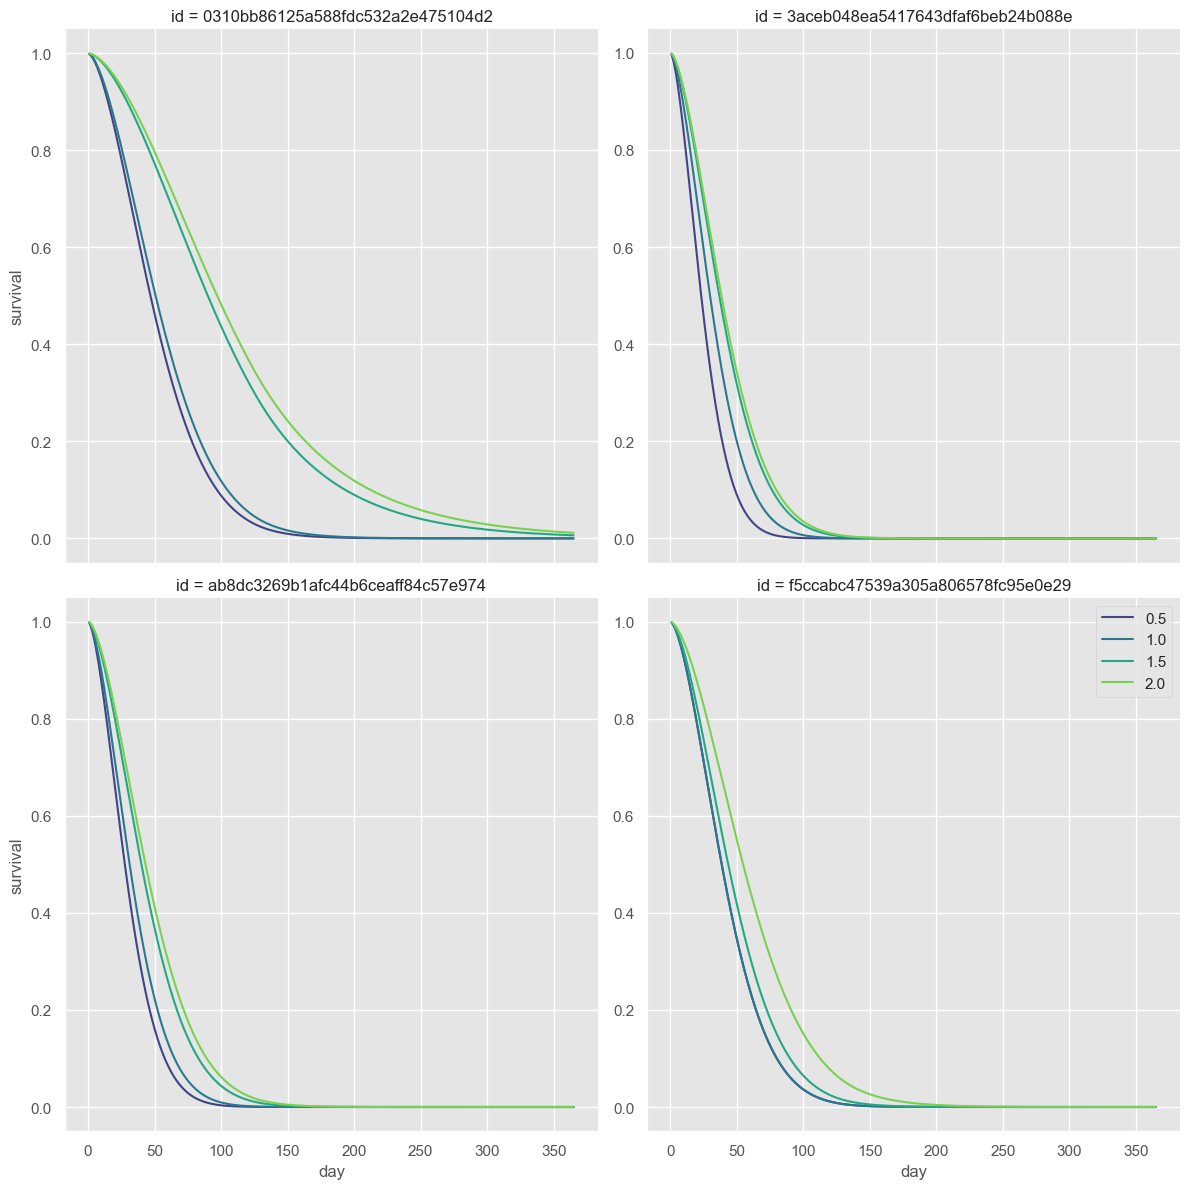

In [196]:
# plot survival curves, facet wrap by id
# set ggplot style
plt.style.use('ggplot')
g = sns.FacetGrid(df_surv_long, col='id', col_wrap=2, hue='label_price', sharey=False, palette='viridis')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.lineplot, 'day', 'survival')
plt.tight_layout()
plt.legend()
plt.show()


# sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='label_price', estimator=None)
# plt.title(f"Theoretical survival times")
# plt.show()